In [1]:
# Jupyter Layout
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1 Note

This notebook uses the convert script and API for NWB v.1.0.6 (not the current NWB 2.0 and PyNWB) to generate NWB v1.0.6 data files and compare with the current format. This notebook is mainly for comparison purposes. The corresponding notebook for converting the MeisterLab example data to NWB 2.x is available here: https://github.com/NeurodataWithoutBorders/pynwb/blob/dev/docs/notebooks/convert-crcns-ret-1-meisterlab.ipynb .

This example is based on https://github.com/NeurodataWithoutBorders/api-python/blob/master/examples/create_scripts/crcns_ret-1.py from H5Gate (i.e., the orignal write API for NWB v1.x). A tar file with the example data is available for download from: https://portal.nersc.gov/project/crcns/download/nwb-1/example_script_data/source_data_2.tar.gz  Please download and uncompress the data file and update the paths in the *Settings* section if you want to run the notebook.  

# 2 Settings

In [2]:
import os, sys

# Location of the example data
indata_dir = "/Volumes/Data Drive/nwb_convert_tutorial/api-python/examples/source_data_2/crcns_ret-1"
# Path were teh h5gate API is located
h5gate_path = '/Volumes/Data Drive/nwb_convert_tutorial/api-python'
# Directory where the output data should be saved
h5gate_output_dir = '/Volumes/Data Drive/nwb_convert_tutorial/convert_test_rerun/nwb1.0.x/' 

# 3 Exectute convert using the orginal H5Gate API

In [3]:
# Add H5Gate to the path
sys.path.append(h5gate_path)
# Check if the convert has been run before
run_h5gate_convert = not os.path.exists(h5gate_output_dir) 

The following is a copy of the following script: https://github.com/NeurodataWithoutBorders/api-python/blob/master/examples/create_scripts/crcns_ret-1.py . Minor modifications were made to paths to make the script work within the notebook indicated by `#MODIFIED` comments. The script is included here to ease comparison and use of the example.

Note, the files generated by the original script are ommitting a few required datasets/attributes and as such do not actually validate. 

In [4]:
if run_h5gate_convert:   # MODIFIED: Added outer if to allow us to avoid running the script again
    #!/usr/bin/python

    # script to convert Meister sample data sets to NWB format
    # modified to use specification language

    import glob
    import sys
    import os
    import h5py
    import datetime
    import numpy as np
    import scipy.io as sio

    from nwb import nwb_file
    from nwb import nwb_utils as ut


    # directory for input data
    SOURCE_DATA_DIR = indata_dir  # MODIFIED: Set to our current input data dir
    path = SOURCE_DATA_DIR + "/Data/"  # MODIFIED: Fix path to fit the notebook

    if not os.path.exists(path):
        # print ("Source files for script '%s' not present." % os.path.basename(__file__))  # MODIFIED: Removed Print
        print ("Download and put them in the 'examples/source_data' directory as instructed")
        print ("in file examples/0_README.txt")
        # sys.exit(1)   # MODIFIED: Do not exit


    file_list = glob.glob(path + "*.mat")
    #file_list = [path+"20080516_R2.mat"]

    if not file_list:
        print ("*** Error:")
        print ("No files found at '%s'.  Cannot run script %s." % (path, os.path.basename(__file__)))
        sys.exit(1)

    # directory for created NWB files.  Must have a trailing slash.
    OUTPUT_DIR = h5gate_output_dir      # MODIFIED: Use our own output directory
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    # this directory for storing generated stimulus files (which are not NWB files).
    STIM_LIBRARY_DIR = OUTPUT_DIR + "stim_library/"
    if not os.path.exists(STIM_LIBRARY_DIR):
        os.makedirs(STIM_LIBRARY_DIR)


    def find_exp_time(fname, data_info):
        try:
            d = data_info["date"][0]
        except IndexError:
            print ("Warning: Unable to read recording date from " + fname)
            return ""
        try:
            rst = data_info["RecStartTime"][0]
        except IndexError:
            print ("Warning: Unable to read recording start time from " + fname)
            return ""
        time = d + str(rst[3]) + str(rst[4]) + str(rst[5])
        dt=datetime.datetime.strptime((time), "%Y%m%d%H%M%S")
        return dt.strftime("%a %b %d %Y %H:%M:%S")

    def find_stim_times(fname, data_info):
        try:
            d = data_info["date"][0]
        except IndexError:
            print ("Error: Unable to read recording date from " + fname)
            assert False
        try:
            rst = data_info['RecStartTime']
        except IndexError:
            print ("Error: Unable to read recording start time from " + fname)
            assert False
        dt = []
        for i in range(len(rst)):
            time = d + str(rst[i][3]) + str(rst[i][4]) + str(rst[i][5])
            dt.append(datetime.datetime.strptime((time), "%Y%m%d%H%M%S"))
        for i in range(1,len(rst)):
            dt[i] = (dt[i] - dt[0]).total_seconds()
        dt[0] = 0.0
        return dt

    def create_stim_ident(x, y, dx, dy):
        return "%dx%d_%dx%d" % (x, y, dx, dy)

    def create_stimulus_file(fname, seed, x, y, dx, dy):
        print ("Creating stimulus file " + fname)
        ident = create_stim_ident(x, y, dx, dy)
        n_pixels = stim_pixel_cnt[ident]
        data = np.zeros(n_pixels)
        with open(SOURCE_DATA_DIR + "/ran1.bin", 'rb') as f:    # MODIFIED: Fix path to fit the notebook
            for i in range(int(n_pixels/8)):  #py3, added int
                byte = f.read(1)
                for j in reversed(range(8)):
                    data[i*8+j] = 255*(ord(byte) >> j & 1)
                # for j in range(8):
                #     data[i*8+j] = 255 * ((ord(byte) >> (7-j)) & 1)
        nx = int(x/dx)  # py3, added int
        ny = int(y/dy)  # py3, added int
        n_frames = int(n_pixels / (nx * ny))  # py3, added int
        # reshape stimulus
        datar = np.reshape(data, (n_frames, ny, nx))
        h5 = h5py.File(fname, 'w')
        grp = h5.create_dataset("image_stack", data=datar, compression=True, dtype='uint8')
        grp.attrs["si_unit"] = "grayscale"
        grp.attrs["resolution"] = "1"
        grp.attrs["conversion"] = "1"
        h5.close()

    def fetch_stimulus_link(seed, x, y, dx, dy):
        # see if stack already exists. if not, create it
        fname = STIM_LIBRARY_DIR + "%s_%d.h5" % (create_stim_ident(x, y, dx, dy), seed)
        if not os.path.isfile(fname):
            # need to create file
            create_stimulus_file(fname, seed, x, y, dx, dy)
        return fname, "image_stack"


    electrode_map = []
    # using 61-channel configuration from Mesiter et al., 1994
    # NOTE: this is an estimate and is used for example purposes only
    for i in range(5): electrode_map.append([(140+70*i),   0, 0])
    for i in range(6): electrode_map.append([(105+70*i),  60, 0])
    for i in range(7): electrode_map.append([( 70+70*i), 120, 0])
    for i in range(8): electrode_map.append([( 30+70*i), 180, 0])
    for i in range(9): electrode_map.append([(    70*i), 240, 0])
    for i in range(8): electrode_map.append([( 30+70*i), 300, 0])
    for i in range(7): electrode_map.append([( 70+70*i), 360, 0])
    for i in range(6): electrode_map.append([(105+70*i), 420, 0])
    for i in range(5): electrode_map.append([(140+70*i), 480, 0])
    electrode_group = []
    for i in range(len(electrode_map)):
        electrode_group.append("61-channel probe")

    print ("Getting stimulus frame requirements")
    stim_pixel_cnt = {}
    for i in range(len(file_list)):
        fname = file_list[i][len(path):]
        mfile = sio.loadmat(file_list[i], struct_as_record=True)
        # prepare matlab data
        data_info = mfile['datainfo'][0,0]
        # 
        stim_offset = find_stim_times(fname, data_info)
        for i in range(len(stim_offset)):
            # create stimuli
            # read data from mat file
            stimulus = mfile["stimulus"][0,i]
            n_frames = stimulus["Nframes"][0,0]
            # figure out how many pixels per frame
            x = stimulus["param"]["x"][0,0][0,0]
            y = stimulus["param"]["y"][0,0][0,0]
            dx = stimulus["param"]["dx"][0,0][0,0]
            dy = stimulus["param"]["dy"][0,0][0,0]
            nx = int(x/dx)
            ny = int(y/dy)
            n_pix = n_frames * nx * ny
            # remember maximum pixel count for this stimulus type
            name = create_stim_ident(x, y, dx, dy)
            if name in stim_pixel_cnt:
                n = stim_pixel_cnt[name]
                if n_pix > n:
                    stim_pixel_cnt[name] = n_pix
            else:
                stim_pixel_cnt[name] = n_pix

    for i in range(len(file_list)):
        fname = file_list[i][len(path):]
        print ("Processing " + fname)
        mfile = sio.loadmat(file_list[i], struct_as_record=True)
        # prepare matlab data
        data_info = mfile['datainfo'][0,0]
        # prepare output file
        vargs = {}
        vargs["start_time"] = find_exp_time(fname, data_info)
        vargs["identifier"] = ut.create_identifier("Meister test data")
        vargs["mode"] = "w"
        vargs["description"] ="Optical stimulation and extracellular recording of retina"
        vargs["file_name"] = OUTPUT_DIR + fname[:-4]+".nwb"    
        bfile = nwb_file.open(**vargs)
        print ("Creating " + vargs["file_name"])
        # get stimulus offset times
        stim_offset = find_stim_times(fname, data_info)
        stim_end = []
        # 
        for i in range(len(stim_offset)):
            # create stimuli
            # read data from mat file
            stimulus = mfile["stimulus"][0,i]
            n_frames = stimulus["Nframes"][0,0]
            frame = stimulus["frame"][0,0]
            onset = stimulus["onset"][0,0]
            type_s = stimulus["type"][0]
            seed = stimulus["param"]["seed"][0,0][0,0]
            x = stimulus["param"]["x"][0,0][0,0]
            y = stimulus["param"]["y"][0,0][0,0]
            dx = stimulus["param"]["dx"][0,0][0,0]
            dy = stimulus["param"]["dy"][0,0][0,0]
            pixel_size = stimulus["pixelsize"][0,0]
            # reformmat for nwb
            timestamps = np.arange(n_frames) * frame + onset + stim_offset[i]
            rec_stim_name = "rec_stim_%d" % (i+1)
            # create stimulus
            img = bfile.make_group("<ImageSeries>", rec_stim_name, path="/stimulus/presentation")
            img.set_custom_dataset("pixel_size", pixel_size)
            img.set_custom_dataset("meister_dx", dx)
            img.set_custom_dataset("meister_dy", dy)
            img.set_custom_dataset("meister_x", x)
            img.set_custom_dataset("meister_y", y)
            img.set_dataset("timestamps", timestamps)
            img.set_dataset("num_samples", len(timestamps))
            file_name, dataset_name = fetch_stimulus_link(seed, x, y, dx, dy)
            file_name_base = file_name[len(OUTPUT_DIR):]  # strip OUTPUT_DIR from front of name
            #- img.set_data_as_remote_link(file_name, dataset_name)
            link_str = "extlink:%s,%s" % (file_name_base, dataset_name)
            img.set_dataset("data", link_str) # special string, causes creation of external link
            img.set_dataset("bits_per_pixel", 8)
            img.set_dataset("format", "raw")
            img.set_dataset("dimension", [int(x/dx), int(y/dy)])  # py3, force to be int
            img.set_attr("description", "type = " + str(type_s) + "; seed = " + str(seed))
            img.set_attr("comments", "Based on ran1.bin. Pixel values are 255 for light, 0 for dark")
            # create epoch
            stim_end = timestamps[-1] + 1
            epoch = ut.create_epoch(bfile, "stim_%d"%(i+1), stim_offset[i], stim_end)
            stim_start = stim_offset[i]
            ts_path = "/stimulus/presentation/"+img.name
            ut.add_epoch_ts(epoch, stim_start, stim_end, "stimulus", ts_path)

        # create module 'Cells' for the spikes    
        mod_name = "Cells"
        mod = bfile.make_group("<Module>", mod_name)
        mod.set_attr("description", "Spike times for the individual cells and stimuli")
        mod.set_attr("source", "Data as reported in the original file")
        # create interfaces
        spk_times_iface = mod.make_group("UnitTimes")
        spk_times_iface.set_attr("source", "Data as reported in the original crcns file")
        # determine number of cells
        spikes_mat = mfile["spikes"]
        num_cells = spikes_mat.shape[0]
        num_stims = spikes_mat.shape[1]
        # unit_list = []  ## Added for specification language conversion method
        for i in range(num_cells):
            cell_name = "cell_%d" %(i+1)
            # unit_list.append(cell_name)   ## Added for specification language conversion method
            cgrp = spk_times_iface.make_group("<unit_N>", cell_name)
            spike_list = []
            for j in range(num_stims):
                stim_name = "stim_%d" % (j+1)
                spikes = np.hstack(spikes_mat[i,j]) + stim_offset[j]
                spike_list.extend(spikes)
                cgrp.set_custom_dataset(stim_name, spikes)
            cgrp.set_dataset("times", spike_list)
            cgrp.set_dataset("unit_description", "none")       
        #- spk_times_iface.finalize()
        # spk_times_iface.set_dataset("unit_list", unit_list) ## Added for specification language conversion method
        #- mod.finalize()

        # write metadata
        rec_no = data_info["RecNo"][0]
        smpl_no = data_info["SmplNo"][0]
        animal = data_info["animal"][0]
        description = data_info["description"][0]
        session_id = "RecNo: " + str(rec_no) + "; SmplNo: " + str(smpl_no)
        bfile.set_dataset("session_id", session_id)
        bfile.set_dataset("experimenter", "Yifeng Zhang")    
        bfile.set_dataset("institution", "Harvard University")
        bfile.set_dataset("lab", "Markus Meister")
        bfile.set_dataset("related_publications", "Yi-Feng Zhang, Hiroki Asari, and Markus Meister (2014); Multi-electrode recordings from retinal ganglion cells. CRCNS.org. http://dx.doi.org/10.6080/K0RF5RZT")
        bfile.set_dataset("notes", str(description))
        bfile.set_dataset("species", "mouse")
        bfile.set_dataset("genotype", str(animal))
        bfile.set_custom_dataset("random_number_generation", "Reference: WH Press, et al. (1992) Numerical Recipes in C, 2nd ed.")
        # bfile.set_custom_metadata_by_file("random_number_generation_code", "ran1.m")
        bfile.set_dataset('electrode_map', electrode_map)
        bfile.set_dataset('electrode_group', electrode_group)
        g =  bfile.make_group('<electrode_group_X>', "61-channel_probe")
        g.set_dataset('description',"Approximation of electrode array used in experiment based on Mester, et. al., 1994 (DEMO DATA)")
        g.set_dataset('location',"Retina flatmount recording")
        g.set_dataset('device', "----")
        print ("\tdone")
        bfile.close()

Getting stimulus frame requirements
Processing 20080516_R1.mat
Creating /Volumes/Data Drive/nwb_convert_tutorial/convert_test_rerun/nwb1.0.x/20080516_R1.nwb
Creating stimulus file /Volumes/Data Drive/nwb_convert_tutorial/convert_test_rerun/nwb1.0.x/stim_library/640x480_1x480_-10000.h5
Creating stimulus file /Volumes/Data Drive/nwb_convert_tutorial/convert_test_rerun/nwb1.0.x/stim_library/640x480_10x10_-10000.h5
Creating stimulus file /Volumes/Data Drive/nwb_convert_tutorial/convert_test_rerun/nwb1.0.x/stim_library/640x480_640x1_-10000.h5
	done

******
Validation messages follow.
** 5 errors.
No Miscellaneous errors. -- Good
No groups missing. -- Good
2 datasets missing:
  1. '/general/extracellular_ephys/filtering'
  2. '/general/extracellular_ephys/impedance'
3 attributes missing (1 combined):
  1. /stimulus/presentation/rec_stim_# - source (#=1-3)
No Incorrect attribute values. -- Good
No groups custom missing attribute neurodata_type=Custom. -- Good
No datasets custom missing attrib

# 4 Compare NWB v1.0.x file with NWB v2.0 file

Compared to the convert using NWB v1.0.x shown above, the NWB 2 convert example makes the following main changes:

* NWB 2.x uses the extension mechanism to add custom data fields rather than adding unspecified custom data directly to the file, i.e., all objects (datasets, attributes, groups etc.) are governed by a formal specification. E.g., in the original script for NWB 1.0.x, pixle_size, meister_x, meister_y, meister_dx, meister_dy were stored as custom datasets in ImageSeries. For NWB 2 we create an extensions MeisterImageSeries which extens ImageSeries and stores those values as attributes pixel_size, x, y, dx, dy. For NWB 2 we chosse attributes instead of datasets simply because these are small, single int and float metadata values for which attributes are more approbirate.
* Change si_unit attribute to unit for compliance with the spec of ImageSeries 
* Moved 'source' attribute from the Module to the Interface as source is not defined in the spec for modules but only for Interface
* Added missing 'source' for SpikeUnit
* Added missing tags and description for epochs
* Added /general/devices/... to describe the device
* Added neurodata_type and namespace attributes for format compliance
* NWBContainer is now a base type of all core neurodata_types and as such `help` and `source` attributes have been added to all core types
* The original script reused iterator variables in nested loops. We have updated those occurance to avoid consusion and avoid possible errors. 
* The following custom metadata fields---i.e., datasets that were originally added to the file without being part of the NWB specification and without creation of corresponding extensions---have not yet been integrated with the NWB files:
    * /general custom metdata: /notes, /random_number_generation, /related_publications. This will require extension of NWBFile to extend the spec of /general. Improvements to make this easier have been proposed for discussion at the upcoming hackathon.
    * SpikeUnit custom datasets with additional copies of the per-stimulus spike times (i.e., /processing/Cells/UnitTimes/cell_*/stim_* in the original version). This will require an extension for SpikeUnit.
    * /subject, subject/genotype, subject/species : See Issue https://bitbucket.org/lblneuro/pynwb/issues/45 support for subject metadata is upcoming in PyNWB 
    * /specifications, /specifications/nwb_core.py : See Issue https://bitbucket.org/lblneuro/pynwb/issues/44 will be added by PyNWB automatically

In [5]:
# Import helper function to render the HDF5 file
interactive = False

try:
    import sys
    sys.path.append('/Users/oruebel/Devel/nwb/nwb-schema/docs')
    from utils.render import NXGraphHierarchyDescription, HierarchyDescription
    if interactive:
        %matplotlib notebook
        %config InlineBackend.figure_format = 'svg'
        autostop_interact = True
    else:
        %matplotlib inline
    import matplotlib.pyplot as plt    
    VIS_AVAILABLE = True
except ImportError:
    VIS_AVAILABLE = False
    print('DISABLING VISUALIZATION OF FILE HIERARCHY')

In [6]:
example_file = '20080516_R1.nwb'  # Pick one file for illustration purposes to compare the file generated by H5Gate and PyNWB
pynwb_example_file = os.path.abspath(os.path.join(os.path.join(h5gate_output_dir, '../nwb2'), example_file))
h5gate_example_file = os.path.join(h5gate_output_dir, example_file)

In [7]:
if VIS_AVAILABLE:
    f1 = HierarchyDescription.from_hdf5(pynwb_example_file)
    f2 = HierarchyDescription.from_hdf5(h5gate_example_file)

    # Compare groups
    g1= set([i['name'] for i in f1['groups']])
    g2= set([i['name'] for i in f2['groups']])
    print("Groups in NWB-1.0.x file not in NWB-2 file")
    for i in (g2-g1):
        print(i)
    print("")
    print("Groups in NWB-2 file not in NWB-1.0.x file")
    for i in (g1-g2):
        print(i)    

    # Compare datasets    
    d1= set([i['name'] for i in f1['datasets']])
    d2= set([i['name'] for i in f2['datasets']])
    print("")
    print("Datasets in NWB-1.0.x file not in NWB-2 file")
    for i in sorted(d2-d1):
        print(i)
    print("")
    print("Datasets in NWB-2 file not in NWB-1.0.x file")
    for i in sorted(d1-d2):
        print(i)    

    # Compare attributes    
    a1= set([i['name'] for i in f1['attributes']])
    a2= set([i['name'] for i in f2['attributes']])
    # Omitted attributes refer to attributes on omitted datasets 
    #for i in sorted(a2-a1):
    #    print(i)
    print("")
    print("Attributes in NWB-2 file not in NWB-1.0.x file")
    for i in sorted(a1-a2):
        print(i)

Groups in NWB-1.0.x file not in NWB-2 file
/general/specifications
/general/subject

Groups in NWB-2 file not in NWB-1.0.x file
/general/devices/----
/general/devices

Datasets in NWB-1.0.x file not in NWB-2 file
/general/extracellular_ephys/61-channel_probe/device
/general/extracellular_ephys/electrode_group
/general/extracellular_ephys/electrode_map
/general/notes
/general/random_number_generation
/general/related_publications
/general/specifications/nwb_core.py
/general/subject/genotype
/general/subject/species
/processing/Cells/UnitTimes/cell_1/stim_1
/processing/Cells/UnitTimes/cell_1/stim_2
/processing/Cells/UnitTimes/cell_1/stim_3
/processing/Cells/UnitTimes/cell_2/stim_1
/processing/Cells/UnitTimes/cell_2/stim_2
/processing/Cells/UnitTimes/cell_2/stim_3
/processing/Cells/UnitTimes/cell_3/stim_1
/processing/Cells/UnitTimes/cell_3/stim_2
/processing/Cells/UnitTimes/cell_3/stim_3
/processing/Cells/UnitTimes/cell_4/stim_1
/processing/Cells/UnitTimes/cell_4/stim_2
/processing/Cells/

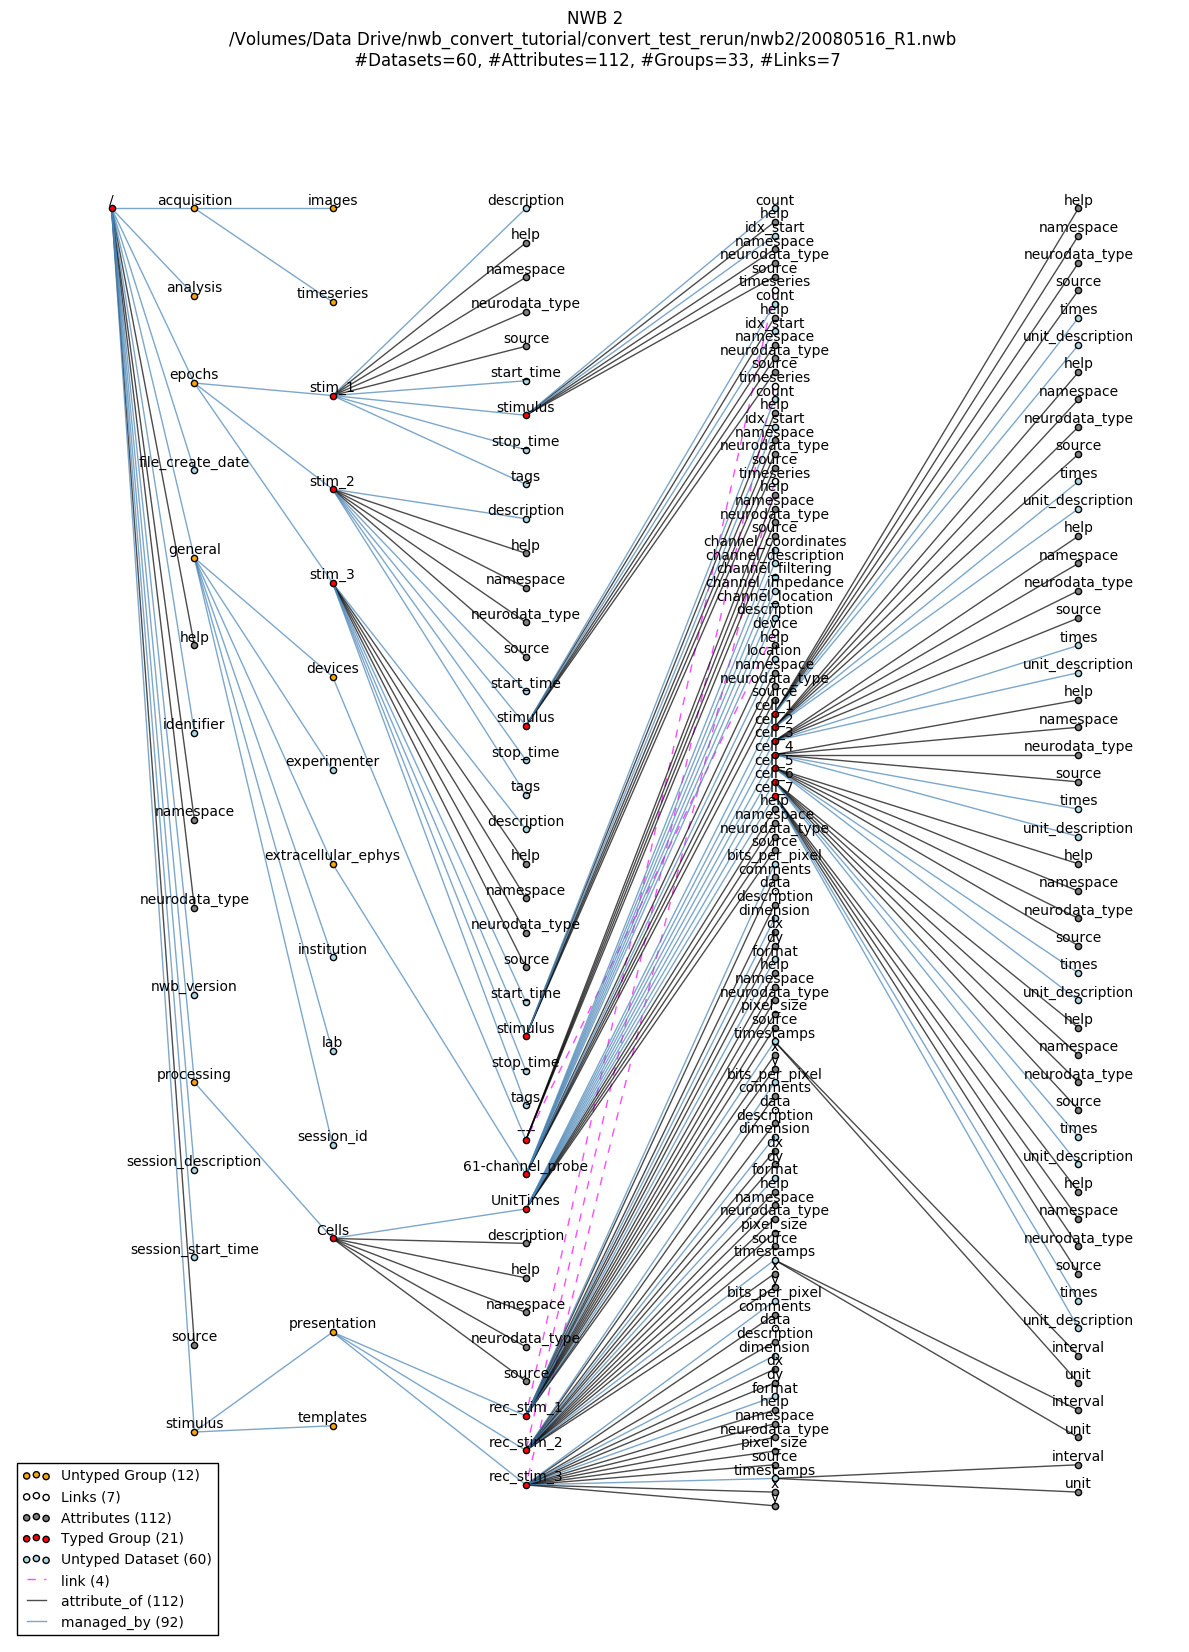

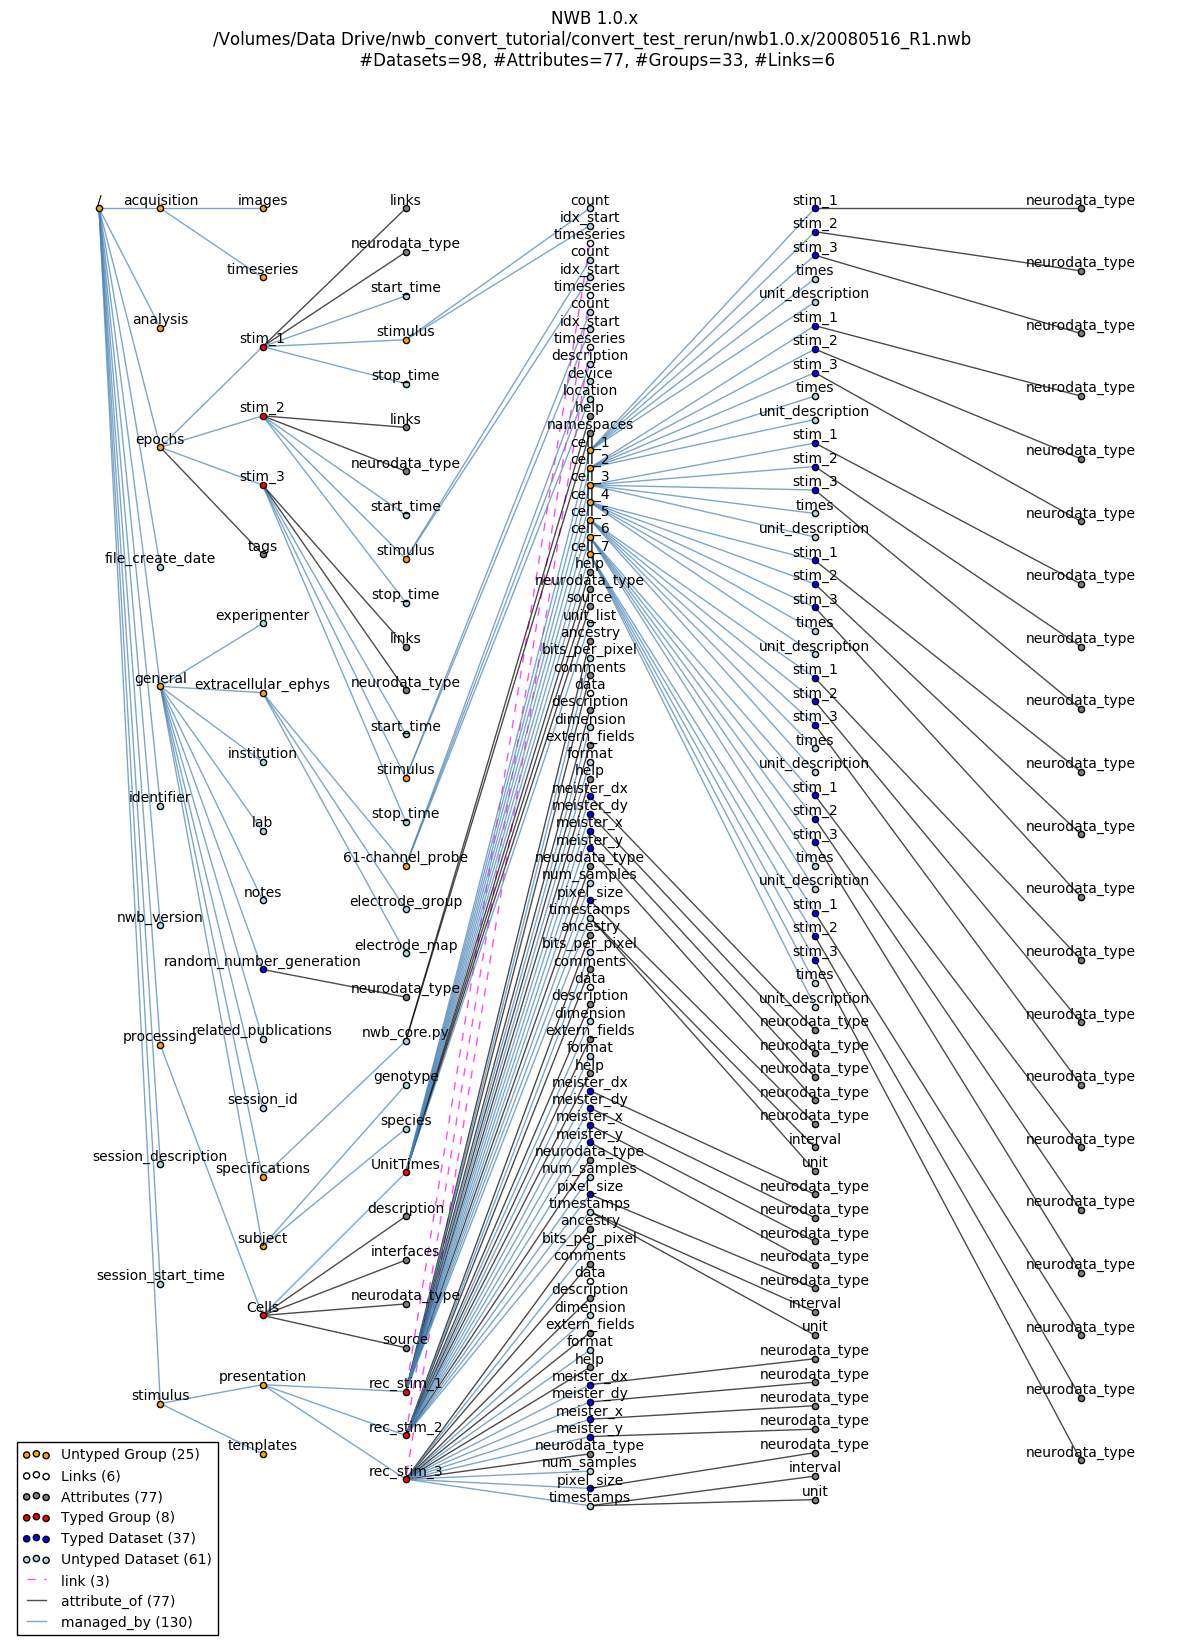

In [8]:
# Import helper function to render the HDF5 file
interactive = False
try:
    import sys
    sys.path.append('/Users/oruebel/Devel/nwb/nwb-schema/docs')
    from utils.render import NXGraphHierarchyDescription, HierarchyDescription
    if interactive:
        %matplotlib notebook
        %config InlineBackend.figure_format = 'svg'
        autostop_interact = True
    else:
        %matplotlib inline
    import matplotlib.pyplot as plt    
    VIS_AVAILABLE = True
except ImportError:
    VIS_AVAILABLE = False
    print('DISABLING VISUALIZATION OF FILE HIERARCHY')

# Plot a select NWB 1.0.6 and a NWB 2.0 file
if VIS_AVAILABLE:
    filenames = [pynwb_example_file, h5gate_example_file]
    headings = ['NWB 2', 'NWB 1.0.x']
    for i, filename in enumerate(filenames):
        file_hierarchy = HierarchyDescription.from_hdf5(filename)  
        file_graph = NXGraphHierarchyDescription(file_hierarchy)          
        fig = file_graph.draw(show_plot=False,
                              figsize=(12,16),
                              label_offset=(0.0, 0.0065),
                              label_font_size=10)
        plot_title = headings[i] + "\n" + filename + " \n " + "#Datasets=%i, #Attributes=%i, #Groups=%i, #Links=%i" % (len(file_hierarchy['datasets']), len(file_hierarchy['attributes']), len(file_hierarchy['groups']), len(file_hierarchy['links']))
        plt.title(plot_title)
        plt.show()